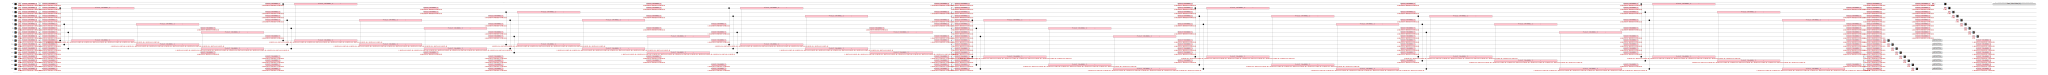

In [36]:
import stim
import numpy as np
from sklearn.model_selection import train_test_split
import os

path = r"C:\Users\conof\Desktop\RNN_QEC\google_qec3v5_experiment_data\surface_code_bX_d3_r05_center_3_5\circuit_noisy.stim"
circuit_google = stim.Circuit.from_file(path)

path2 = r"C:\Users\conof\Desktop\RNN_QEC\surface-sim\scripts\biased_noise_datagen\test\surf-code_d3_bZ_s000000000_n20000_r1\circuit.stim"
circuit_Delft = stim.Circuit.from_file(path2)

distance=3
rounds=5

if distance ==3:
    num_qubits=17
    num_data_qubits=9
    num_ancilla_qubits=8

if distance ==5:
    num_qubits=49
    num_data_qubits=25
    num_ancilla_qubits=24

circuit_Delft.diagram('timeline-svg')

# # Compile the sampler
# sampler = circuit.compile_detector_sampler()
# # Sample shots, with observables
# samples = sampler.sample(1, separate_observables=True)
# print(samples)



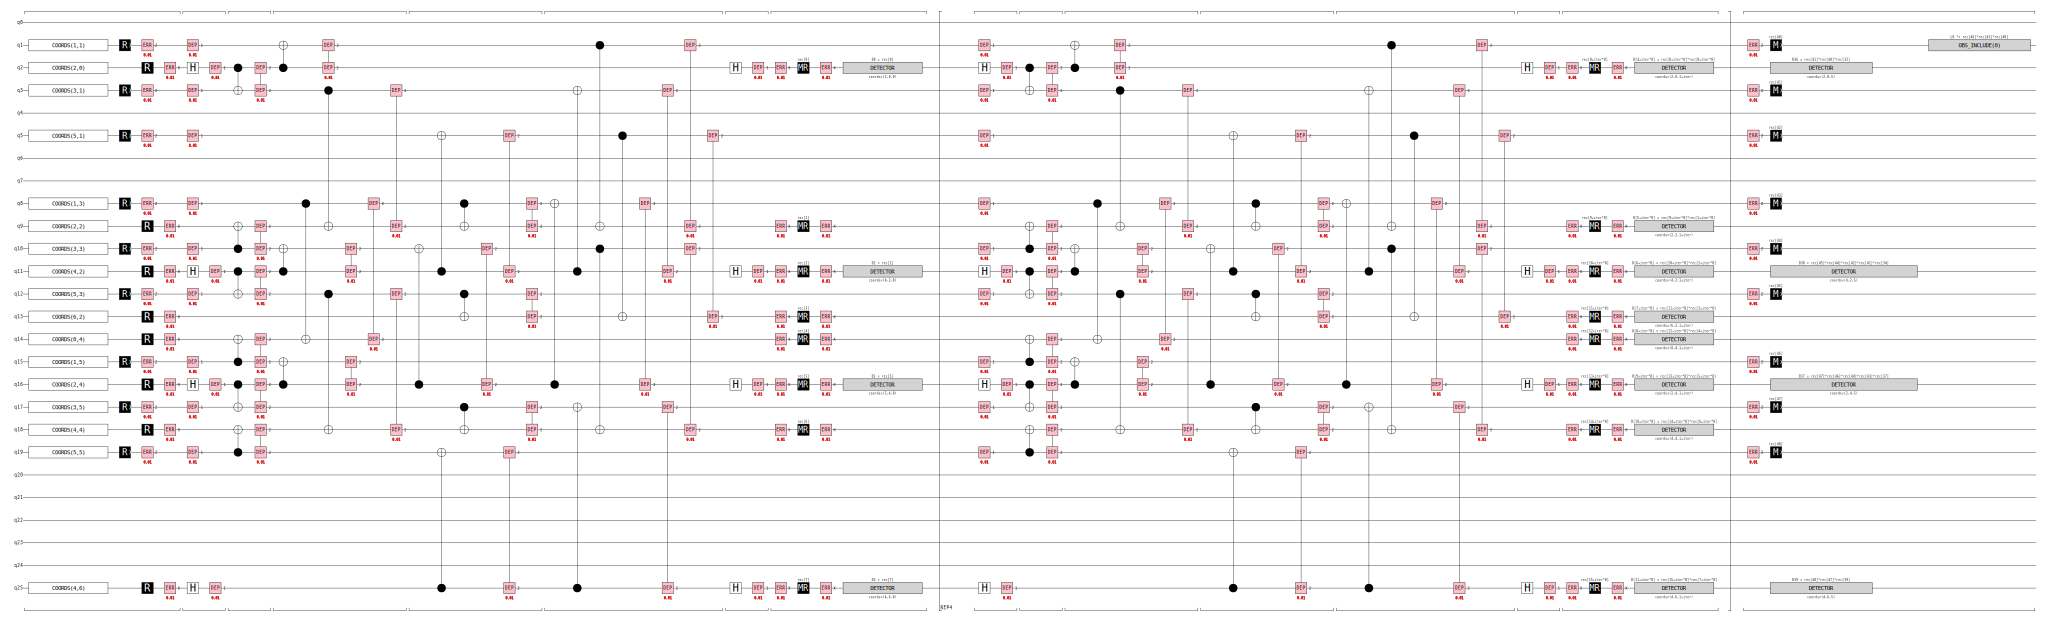

In [37]:
circuit_surface = stim.Circuit.generated(
    "surface_code:rotated_memory_x",
    rounds=5,
    distance=3,
    after_clifford_depolarization=0.01,
    after_reset_flip_probability=0.01,
    before_measure_flip_probability=0.01,
    before_round_data_depolarization=0.01)

circuit_surface.diagram("timeline-svg")

In [38]:
num_shots=2000000
# Compile the sampler
sampler = circuit_google.compile_detector_sampler()
# Sample shots, with observables
detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)


detection_events = detection_events.astype(int)
detection_strings = [''.join(map(str, row)) for row in detection_events] #compress the detection events in a tensor
detection_events_numeric = [[int(value) for value in row] for row in detection_events] # Convert string elements to integers (or floats if needed)
detection_array = np.array(detection_events_numeric) # Convert detection_events to a numpy array
print(detection_array[0])

detection_array1 = detection_array.reshape(num_shots, rounds, num_ancilla_qubits) #first dim is the number of shots, second dim round number, third dim is the Ancilla 
print(detection_array1[0]) 


observable_flips = observable_flips.astype(int).flatten().tolist()


test_size=0.2
test_dataset_size=num_shots*test_size
X_train, X_test, y_train, y_test = train_test_split(detection_array1, observable_flips, test_size=0.2, random_state=42, shuffle=False)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 1 1 1 1]
 [1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot

# RNN model
class BinaryRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BinaryRNN, self).__init__()
        self.hidden_size = hidden_size
        self.fc = nn.Linear(input_size, input_size)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # For binary output
    
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out1=out[:, -1, :]
        out = self.fc(out1)  # Use the last time-step's output, needed for changing the dimension of the output compared of input
        out = self.sigmoid(out)  # I need a Binary output
        return out, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

# LSTM model    
class BinaryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BinaryLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # For binary output
    
    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # Use the last time-step's output, needed for changing the dimension of the output compared of input
        out = self.sigmoid(out)  # I need a Binary output
        return out, hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size),  # Hidden state
                torch.zeros(1, batch_size, self.hidden_size))  # Cell state



# Function to convert binary string to tensor
def binary_array_to_tensor(binary_array):
    # Check if the input is a NumPy array, if not, convert it
    if isinstance(binary_array, np.ndarray):
        tensor = torch.from_numpy(binary_array).float()  # Convert NumPy array to float32 tensor
    else:
        # If not a NumPy array, convert it as before
        tensor = torch.tensor([[int(bit) for bit in binary_array]], dtype=torch.float32)
    return tensor



# Training function
def train(model, binary_sequences, targets, num_epochs, learning_rate, batch_size):
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Calculate number of batches
    num_batches = len(binary_sequences) // batch_size
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        for batch_idx in range(num_batches):
            # Get batch data
            batch_sequences = binary_sequences[batch_idx * batch_size : (batch_idx + 1) * batch_size]
            batch_targets = targets[batch_idx * batch_size : (batch_idx + 1) * batch_size]
            
            optimizer.zero_grad()
            
            # Initialize hidden state for the batch with batch size
            hidden = model.init_hidden(batch_size=batch_size)
            
            # Forward pass through each sequence in the batch
            batch_loss = 0
            
            input_tensor = binary_array_to_tensor(batch_sequences)  # Prepare input tensor for batch
            output, hidden = model(input_tensor, hidden)  # Forward pass
             # Adjust dimensions if necessary
            target_tensor = torch.tensor(batch_targets).float()
            loss = criterion(output.squeeze(1), target_tensor)
            batch_loss += loss.item()
            
            # Compute the average loss for the batch
            batch_loss = batch_loss / batch_size
            total_loss += batch_loss
            
            # Backward pass and optimization step
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/num_batches:.4f}')


In [40]:
def test(model, binary_sequences, targets, batch_size):
    model.eval()  # Set the model to evaluation mode (disable dropout, etc.)
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation for testing
        # Calculate number of batches
        num_batches = len(binary_sequences) // batch_size
        
        for batch_idx in range(num_batches):
            # Get batch data
            batch_sequences = binary_sequences[batch_idx * batch_size : (batch_idx + 1) * batch_size]
            batch_targets = targets[batch_idx * batch_size : (batch_idx + 1) * batch_size]
            
            # Convert batch sequences to a tensor
            input_tensor = torch.stack([binary_array_to_tensor(seq) for seq in batch_sequences])  # Shape: (batch_size, seq_length, input_size)
            
            # Initialize hidden state for the batch
            hidden = model.init_hidden(batch_size=batch_size)
            
            # Forward pass
            outputs, hidden = model(input_tensor, hidden)
            
            # Convert outputs to binary predictions (0 or 1)
            predictions = torch.round(outputs.squeeze()).int()  # Convert probabilities to binary
            
            # Check predictions against targets
            for pred, target in zip(predictions, batch_targets):
                if pred.item() == target:
                    correct += 1
                total += 1

        # Calculate accuracy
        accuracy = correct / total
        print(f'Test Accuracy: {accuracy * 100:.2f}%')


In [41]:
# Define parameters
input_size = num_ancilla_qubits # Each input is a Detection round, vector of mmt of the Ancilla
hidden_size =64  # You can experiment with different sizes
output_size = 1  # Output is the value of the observable after the mmt cycles
batch_size=256
learning_rate=0.0005
num_epochs=10

# Create an instance of the RNN model
model = BinaryRNN(input_size, hidden_size, output_size)

# Train the model
train(model, X_train, y_train, num_epochs, learning_rate, batch_size)
    
test(model, X_test, y_test,batch_size)



Epoch [1/10], Loss: 0.0020
Epoch [2/10], Loss: 0.0017
Epoch [3/10], Loss: 0.0015
Epoch [4/10], Loss: 0.0014
Epoch [5/10], Loss: 0.0014
Epoch [6/10], Loss: 0.0013
Epoch [7/10], Loss: 0.0013
Epoch [8/10], Loss: 0.0013
Epoch [9/10], Loss: 0.0013
Epoch [10/10], Loss: 0.0013
Test Accuracy: 85.38%


In [42]:
import os

torch.save(model.state_dict(), 'binary_rnn_model.onnx')

dummy_input = torch.randn(1, rounds, num_ancilla_qubits)  # Create a dummy input
hidden_state = model.init_hidden(1)  # Initialize hidden state

# Export the model to ONNX format
# Define the directory where you want to save the model
path = r'C:\Users\conof\Desktop\RNN_QEC'
output_directory =  path
output_filename = 'binary_rnn_model.onnx'  # Desired file name

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Export the model to ONNX format in the specified directory
torch.onnx.export(
    model,
    (dummy_input, hidden_state),
    os.path.join(output_directory, output_filename),  # Full path to save the model
    input_names=['input'],
    output_names=['output'])

c:\Users\conof\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\onnx\symbolic_opset9.py:2119: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with RNN_TANH can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn("Exporting a model to ONNX with a batch_size other than 1, " +


In [44]:
import pymatching

detector_error_model = circuit_google.detector_error_model(decompose_errors=True)
matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

detection_test=detection_events[-int(test_dataset_size):]
observable_test=observable_flips[-int(test_dataset_size):]


# Run the decoder with the test samples
predictions = matcher.decode_batch(detection_test)

# Count the mistakes.
num_errors = 0
for shot in range(int(test_dataset_size)):
    actual_for_shot = observable_test[shot]
    predicted_for_shot = predictions[shot][0]
    if not np.array_equal(actual_for_shot, predicted_for_shot):
        num_errors += 1

print((test_dataset_size-num_errors)/test_dataset_size)

0.864385
